In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter
import corner

In [2]:
import xoflares

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)


0.1.5
1.0.4
3.5


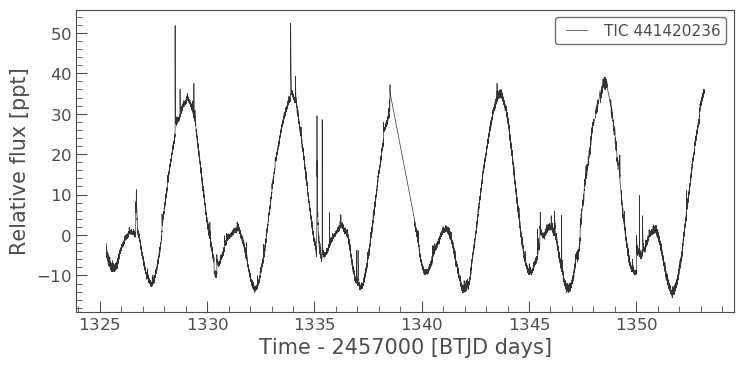

In [10]:
target = 'AU Mic'
#lcf = lk.search_lightcurvefile(target).download(quality_bitmask='hard',)
lcf = lk.TessLightCurveFile('/Users/emilygilbert/Downloads/MAST_2019-03-19T1450/TESS/tess2018206045859-s0001-0000000441420236-0120-s/tess2018206045859-s0001-0000000441420236-0120-s_lc.fits')
lc = lcf.get_lightcurve('PDCSAP_FLUX').remove_nans().normalize()

lc.flux = (lc.flux - 1.0)  * 1e3
texp = lcf.hdu[1].header['FRAMETIM'] * lcf.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (lcf.time.min() + lcf.time.max())

lc.plot(normalize=False, ylabel='Relative flux [ppt]')

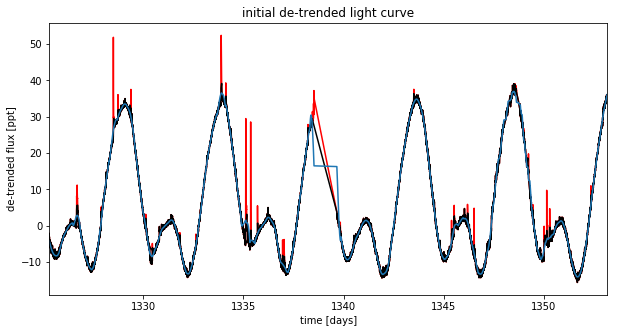

In [11]:
# get a smoothed version of the light curve
smooth = savgol_filter(lc.flux, 301, polyorder=2)
resid = lc.flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux, "r")
plt.plot(lc.time[mask], lc.flux[mask], "k")
plt.plot(lc.time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(lc.time.min(), lc.time.max());

In [12]:
# find some flares
mflare = resid < 3.5 * np.sqrt(np.mean(resid**2))
cads = lc.cadenceno - lc.cadenceno[0]
x = lc.time - ref_time
y = resid #  we're working with the data with a savgol subtracted

fidx = cads[~mflare][:-1] #[np.diff(cads[~mflare]) < 1]
npts = np.array([])
i = 0
n = 1
while True:
    try:
        if fidx[i + 1] == fidx[i] + n:
            fidx = np.delete(fidx, i + 1)
            n += 1
        else:
            npts = np.r_[npts, n+1]
            i += 1
            n = 1
    except IndexError:
        npts = np.r_[npts, n+1]
        break
tpeaks = np.array([x[(lc.cadenceno - lc.cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
ampls = np.array([resid[(lc.cadenceno - lc.cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
fwhms = np.asarray(npts) * (2/1440)
npeaks = np.shape(tpeaks)[0]
print(npeaks)

21


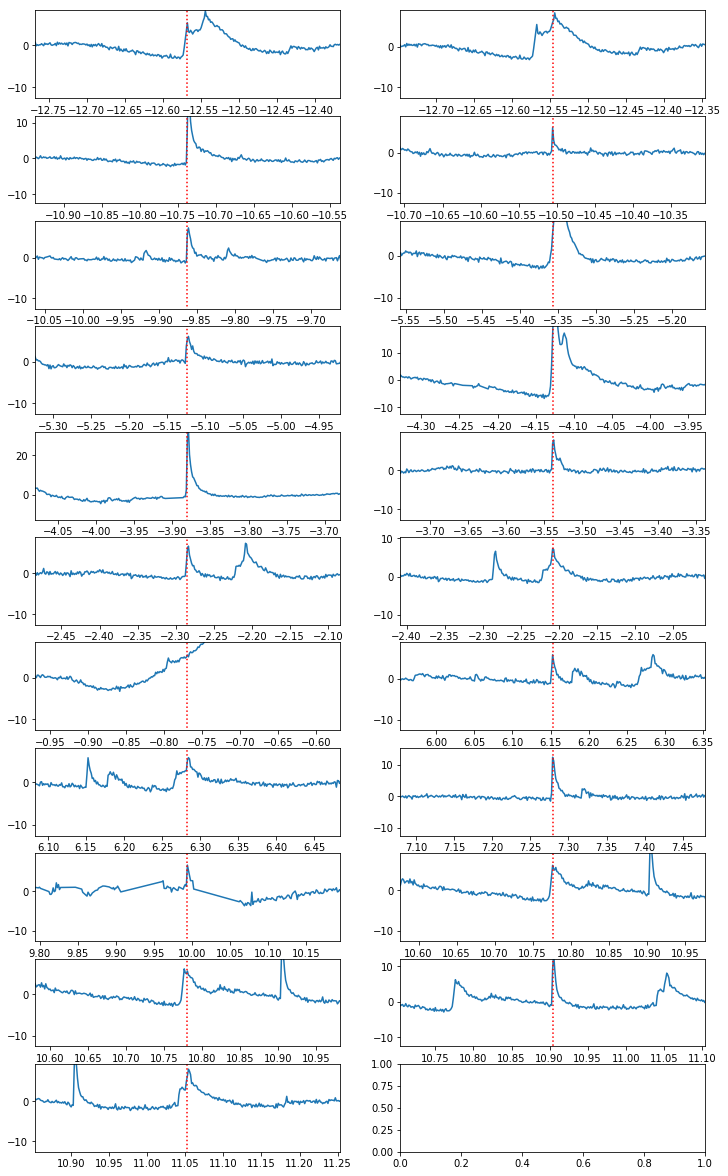

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y), np.max(ampls[i]+3))

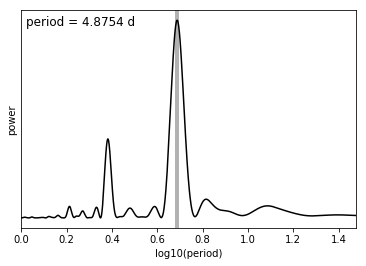

In [14]:
y = lc.flux
yerr = lc.flux_err * 1e3

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

In [15]:
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0, sd=15.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=0.2)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
        logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
        logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
        fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
        ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
        
        light_curve = xoflares.get_light_curve(x[mask], tpeak, fwhm, ampl, texp=texp, oversample=9)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curve

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak,fwhm, ampl])
    return model, map_soln

model0, map_soln0 = build_model()

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

optimizing logp for variables: ['logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Optimization terminated successfully.
logp: -49781.64541938059 -> -21923.590285067057
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


message: Optimization terminated successfully.
logp: -21923.590285067057 -> -15583.76743895079


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -15583.76743895079 -> -14489.852747172179
optimizing logp for variables: ['mean', 'logAmpl']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


message: Optimization terminated successfully.
logp: -14489.852747172179 -> -14061.575060384497
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -14061.575060384497 -> -14040.638832119046


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -14040.638832119046 -> -12715.827901359231
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


message: Optimization terminated successfully.
logp: -12715.827901359231 -> -12467.362782909204
optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -12467.362782909204 -> -12467.362782909204
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -12467.362782909204 -> -11838.64178813028
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -11838.64178813028 -> -11655.708087439221
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -11655.708087439221 -> -11004.600878233092
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -11004.600878233092 -> -10985.161755281455
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -10985.161755281455 -> -10938.489171172596
optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -10938.489171172596 -> -10934.184811969566


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


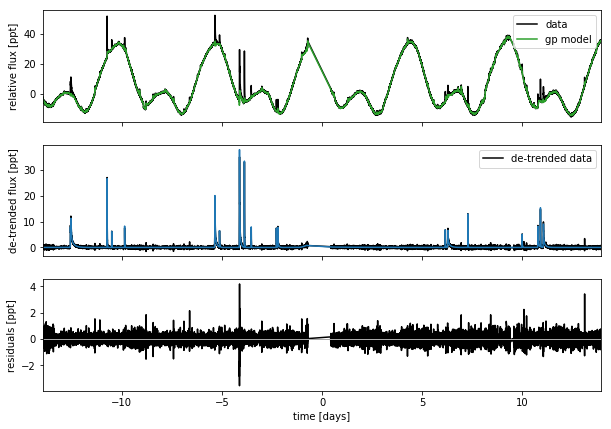

In [16]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curve = xo.utils.eval_in_model(model.light_curves, soln, model=model)

    mod = light_curve
    ax.plot(x[mask], mod,)
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + light_curve
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

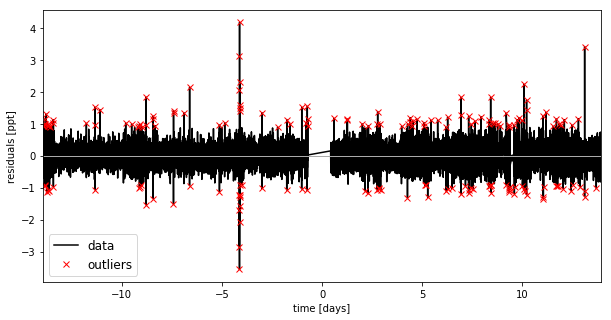

In [17]:
mod = map_soln0["pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: ['logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -10934.184811969566 -> -10919.197973868713
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -10919.197973868713 -> -10742.500611801779
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -10742.500611801779 -> -10712.331235906897
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -10712.331235906897 -> -10710.90890156731
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -10710.90890156731 -> -10707.944626274995
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -10707.944626274995 -> -10691.890656299136
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -10691.890656299136 -> -10681.875823393299
optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -10681.875823393299 -> -10681.875823393299
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -10681.875823393299 -> -10677.516585627993
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -10677.516585627993 -> -10671.61377344942
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -10671.61377344942 -> -10671.340211167599
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -10671.340211167599 -> -10671.265327500738
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -10671.265327500738 -> -10664.976323103843
optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -10664.976323103843 -> -10664.137260796397


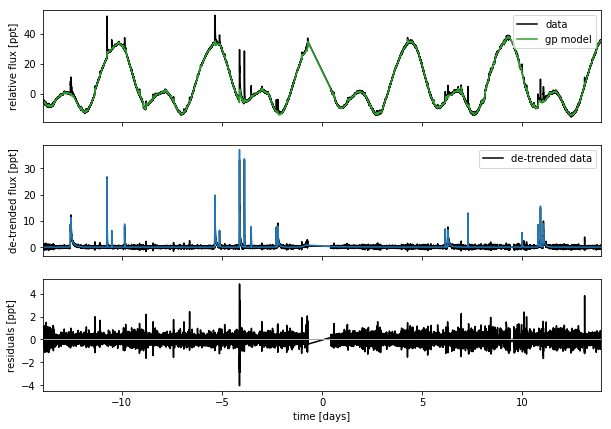

In [18]:

model, map_soln1 = build_model(mask=None, start=map_soln0)
fig = plot_light_curve(model, map_soln1, mask=None)

In [19]:
with model:
    map_soln2 = xo.optimize(start=map_soln1,)


optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak', 'mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -10664.137260796397 -> -10664.13449121893


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [ ]:
# sampler = xo.PyMC3Sampler(window=200, start=500, finish=500)
# with model:
#     burnin = sampler.tune(tune=4500, start=map_soln2,
#                           step_kwargs=dict(target_accept=0.9),
#                           chains=4)

In [ ]:
# with model:
#     trace = sampler.sample(draws=3000, chains=4)

In [20]:
with model:
    mean_field = pm.fit(method='advi', start=map_soln2,  n=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Average Loss = 11,094: 100%|██████████| 100000/100000 [3:31:50<00:00,  8.75it/s]      
Finished [100%]: Average Loss = 11,093


In [21]:
with model:
    trace = mean_field.sample(3000)

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Prot = 4.880015925291026 +0.05792027568305258 - 0.0584485570808253


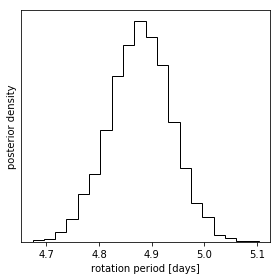

In [22]:
fig, axes = plt.subplots(1,1, figsize=[4, 4])
ax = axes
ax.hist( trace['period'], bins=20, histtype='step', color="k")
plt.yticks([])

ax.set_xlabel("rotation period [days]")
ax.set_ylabel("posterior density");

plt.tight_layout()
fig.savefig('aumic-rotation.png', dpi=200)
q = np.percentile(trace['period'], [16,50,84])
print('Prot = {} +{} - {}'.format(q[1], q[2] - q[1], q[1]-q[0]))


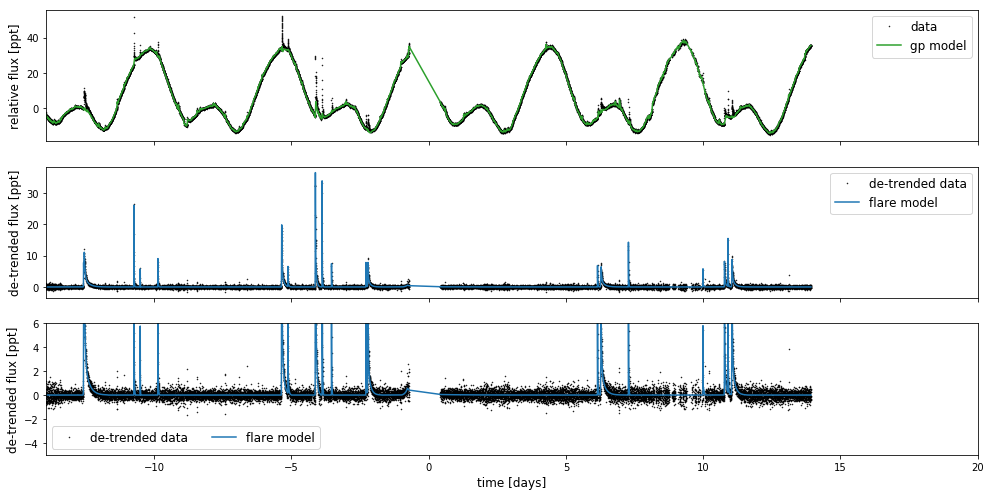

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

ax = axes[0]
ax.plot(x, y, ".k", label="data", ms=1)
gp_mod = np.median(trace['pred'], axis=0)
gp_mod += np.median(trace["mean"])
ax.plot(x, gp_mod, color="C2", label="gp model")
ax.legend(fontsize=12)
ax.set_ylabel("relative flux [ppt]", fontsize=12)

ax = axes[1]
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
light_curve = np.median(trace['light_curve'], axis=0)

mod = light_curve
ax.plot(x, mod, label='flare model')
ax.legend(fontsize=12)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)

ax = axes[2]
# mod = gp_mod + light_curve
# ax.plot(x, y - mod, "k")
# ax.axhline(0, color="#aaaaaa", lw=1)
# ax.set_ylabel("residuals [ppt]", fontsize=12)
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
ax.plot(x, mod, label='flare model')

ax.legend(fontsize=12, loc=3, ncol=2)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)
ax.set_ylim(-5,6)

ax.set_xlim(x.min(), 20)#-5)
ax.set_xlabel("time [days]", fontsize=12)

plt.tight_layout()

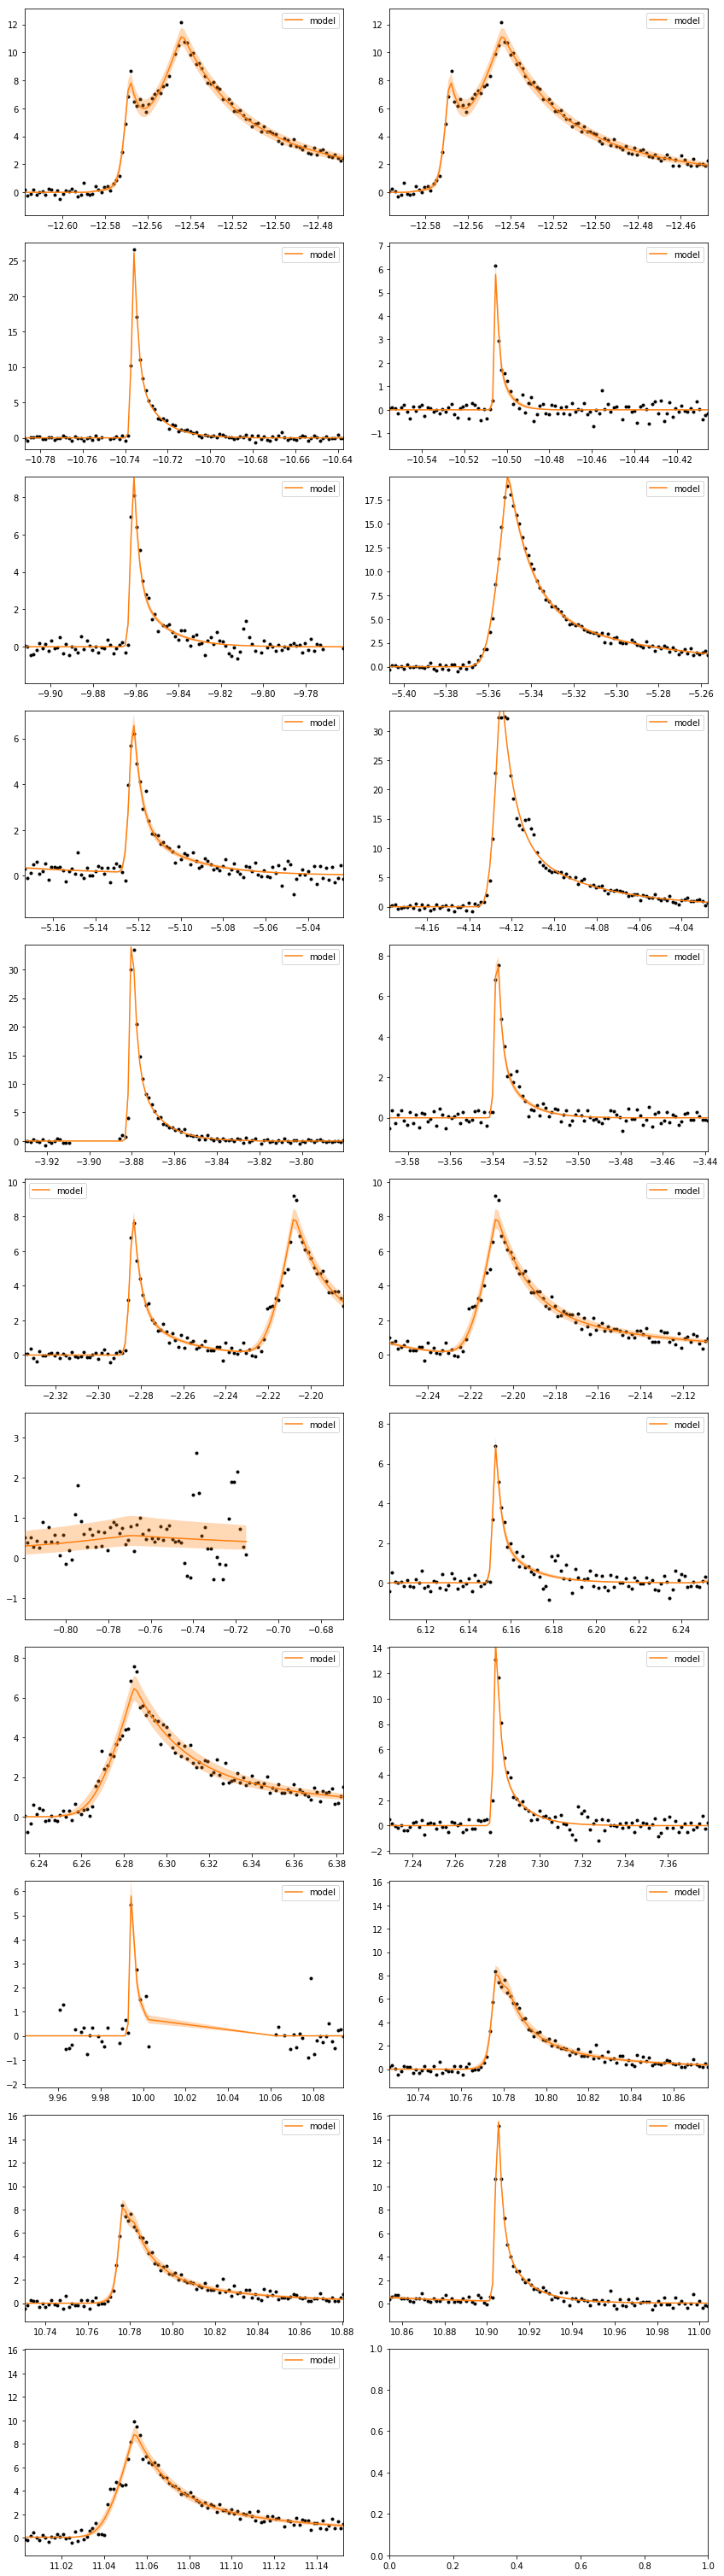

In [24]:
flc =  np.percentile(trace['light_curve'], [16, 50, 84], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask]-gp_mod[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    ax.set_ylim(np.min(y[timemask]-gp_mod[timemask]) - 1, 1 + np.max(y[timemask]-gp_mod[timemask]))
    ax.legend()
    
fig.tight_layout()